# Tutorial: Enhancing PINNs with Extra Features to solve the Poisson Problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial2/tutorial.ipynb)

This tutorial presents how to solve with Physics-Informed Neural Networks (PINNs) a 2D Poisson problem with Dirichlet boundary conditions. We will train with standard PINN's training, and with extrafeatures. For more insights on extrafeature learning please read [*An extended physics informed neural network for preliminary analysis of parametric optimal control problems*](https://www.sciencedirect.com/science/article/abs/pii/S0898122123002018).

First of all, some useful imports.

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import warnings

from pina import LabelTensor, Trainer
from pina.model import FeedForward
from pina.solver import PINN
from torch.nn import Softplus

warnings.filterwarnings("ignore")

## The problem definition

The two-dimensional Poisson problem is mathematically written as:
\begin{equation}
\begin{cases}
\Delta u = 2\pi^2\sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u = 0 \text{ on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}
where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square.

The Poisson problem is written in **PINA** code as a class. The equations are written as *conditions* that should be satisfied in the corresponding domains. The *solution*
is the exact solution which will be compared with the predicted one. If interested in how to write problems see [this tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial16/tutorial.html).

We will directly import the problem from `pina.problem.zoo`, which contains a vast list of PINN problems and more.

In [2]:
from pina.problem.zoo import Poisson2DSquareProblem as Poisson

# initialize the problem
problem = Poisson()

# print the conditions
print(
    f"The problem is made of {len(problem.conditions.keys())} conditions: \n"
    f"They are: {list(problem.conditions.keys())}"
)

# let's discretise the domain
problem.discretise_domain(30, "grid", domains=["D"])
problem.discretise_domain(100, "grid", domains=["boundary"])

The problem is made of 2 conditions: 
They are: ['boundary', 'D']


## Solving the problem with standard PINNs

After the problem, the feed-forward neural network is defined, through the class `FeedForward`. This neural network takes as input the coordinates (in this case $x$ and $y$) and provides the unkwown field of the Poisson problem. The residual of the equations are evaluated at several sampling points and the loss minimized by the neural network is the sum of the residuals.

In this tutorial, the neural network is composed by two hidden layers of 10 neurons each, and it is trained for 1000 epochs with a learning rate of 0.006 and $l_2$ weight regularization set to $10^{-8}$. These parameters can be modified as desired. We set the `train_size` to 0.8 and `test_size` to 0.2, this mean that the discretised points will be divided in a 80%-20% fashion, where 80% will be used for training and the remaining 20% for testing.

In [ ]:
# make model + solver + trainer
from pina.optim import TorchOptimizer

model = FeedForward(
    layers=[10, 10],
    func=Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables),
)
pinn = PINN(
    problem,
    model,
    optimizer=TorchOptimizer(torch.optim.Adam, lr=0.006, weight_decay=1e-8),
)
trainer_base = Trainer(
    solver=pinn,  # setting the solver, i.e. PINN
    max_epochs=1000,  # setting max epochs in training
    accelerator="cpu",  # we train on cpu, also other are available
    enable_model_summary=False,  # model summary statistics not printed
    train_size=0.8,  # set train size
    val_size=0.0,  # set validation size
    test_size=0.2,  # set testing size
    shuffle=True,  # shuffle the data
)

# train
trainer_base.train()

Now we plot the results using `matplotlib`.
The solution predicted by the neural network is plotted on the left, the exact one is in the center and on the right the error between the exact and the predicted solutions is showed. 

In [4]:
@torch.no_grad()
def plot_solution(solver):
    # get the problem
    problem = solver.problem
    # get spatial points
    spatial_samples = problem.spatial_domain.sample(30, "grid")
    # compute pinn solution, true solution and absolute difference
    data = {
        "PINN solution": solver(spatial_samples),
        "True solution": problem.solution(spatial_samples),
        "Absolute Difference": torch.abs(
            solver(spatial_samples) - problem.solution(spatial_samples)
        ),
    }
    # plot the solution
    for idx, (title, field) in enumerate(data.items()):
        plt.subplot(1, 3, idx + 1)
        plt.title(title)
        plt.tricontourf(  # convert to torch tensor + flatten
            spatial_samples.extract("x").tensor.flatten(),
            spatial_samples.extract("y").tensor.flatten(),
            field.tensor.flatten(),
        )
        plt.colorbar(), plt.tight_layout()

Here the solution:

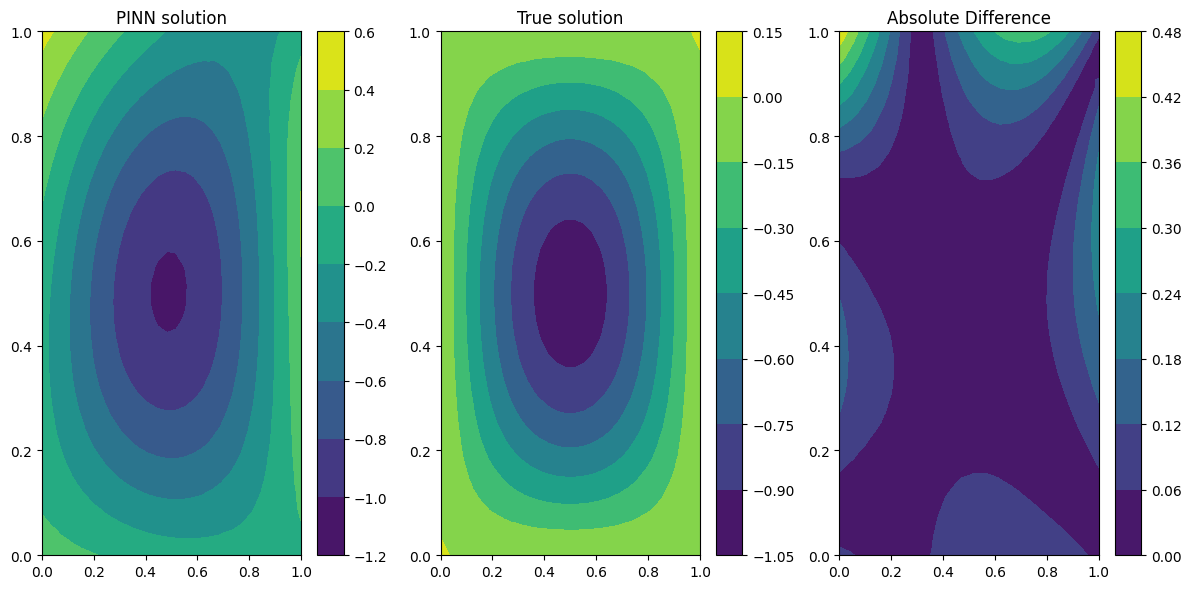

In [5]:
plt.figure(figsize=(12, 6))
plot_solution(solver=pinn)

As you can see the solution is not very accurate, in what follows we will use **Extra Feature** as introduced in [*An extended physics informed neural network for preliminary analysis of parametric optimal control problems*](https://www.sciencedirect.com/science/article/abs/pii/S0898122123002018) to boost the training accuracy. Of course, even extra training will benefit, this tutorial is just to show that convergence using Extra Features is usally faster.

## Solving the problem with extra-features PINNs

Now, the same problem is solved in a different way.
A new neural network is now defined, with an additional input variable, named extra-feature, which coincides with the forcing term in the Laplace equation. 
The set of input variables to the neural network is:

\begin{equation}
[x, y, k(x, y)], \text{ with } k(x, y)= 2\pi^2\sin{(\pi x)}\sin{(\pi y)},
\end{equation}

where $x$ and $y$ are the spatial coordinates and $k(x, y)$ is the added feature which is equal to the forcing term.

This feature is initialized in the class `SinSin`, which is a simple `torch.nn.Module`. After declaring such feature, we can just adjust the `FeedForward` class by creating a subclass `FeedForwardWithExtraFeatures` with an adjusted forward method and the additional attribute `extra_features`.

Finally, we perform the same training as before: the problem is `Poisson`, the network is composed by the same number of neurons and optimizer parameters are equal to previous test, the only change is the new extra feature.

In [ ]:
class SinSin(torch.nn.Module):
    """Feature: sin(x)*sin(y)"""

    def __init__(self):
        super().__init__()

    def forward(self, pts):
        x, y = pts.extract(["x"]), pts.extract(["y"])
        f = 2 * torch.pi**2 * torch.sin(x * torch.pi) * torch.sin(y * torch.pi)
        return LabelTensor(f, ["feat"])


class FeedForwardWithExtraFeatures(FeedForward):
    def __init__(self, *args, extra_features, **kwargs):
        super().__init__(*args, **kwargs)
        self.extra_features = extra_features

    def forward(self, x):
        extra_feature = self.extra_features(x)  # we append extra features
        x = x.append(extra_feature)
        return super().forward(x)


model_feat = FeedForwardWithExtraFeatures(
    input_dimensions=len(problem.input_variables) + 1,
    output_dimensions=len(problem.output_variables),
    func=Softplus,
    layers=[10, 10],
    extra_features=SinSin(),
)

pinn_feat = PINN(
    problem,
    model_feat,
    optimizer=TorchOptimizer(torch.optim.Adam, lr=0.006, weight_decay=1e-8),
)
trainer_feat = Trainer(
    solver=pinn_feat,  # setting the solver, i.e. PINN
    max_epochs=1000,  # setting max epochs in training
    accelerator="cpu",  # we train on cpu, also other are available
    enable_model_summary=False,  # model summary statistics not printed
    train_size=0.8,  # set train size
    val_size=0.0,  # set validation size
    test_size=0.2,  # set testing size
    shuffle=True,  # shuffle the data
)

trainer_feat.train()

The predicted and exact solutions and the error between them are represented below.
We can easily note that now our network, having almost the same condition as before, is able to reach additional order of magnitudes in accuracy.

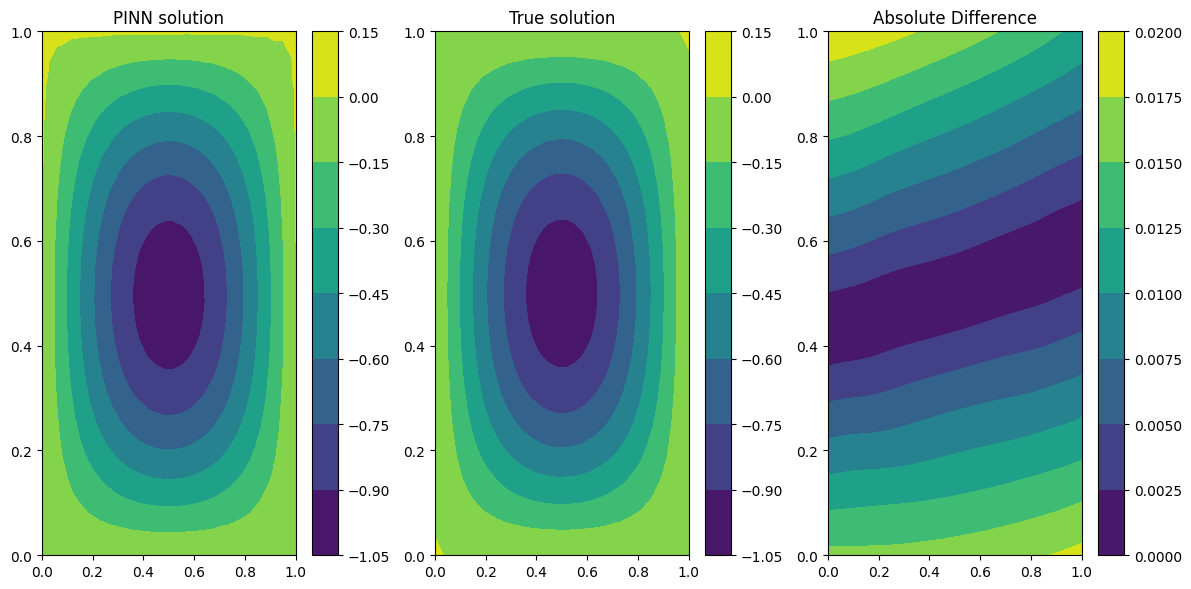

In [7]:
plt.figure(figsize=(12, 6))
plot_solution(solver=pinn_feat)

## Solving the problem with learnable extra-features PINNs

We can still do better!

Another way to exploit the  extra features is the addition of learnable parameter inside them.
In this way, the added parameters are learned during the training phase of the neural network. In this case, we use:

\begin{equation}
k(x, \mathbf{y}) = \beta \sin{(\alpha x)} \sin{(\alpha y)},
\end{equation}

where $\alpha$ and $\beta$ are the abovementioned parameters.
Their implementation is quite trivial: by using the class `torch.nn.Parameter` we cam define all the learnable parameters we need, and they are managed by `autograd` module!

In [ ]:
class SinSinAB(torch.nn.Module):
    """ """

    def __init__(self):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.tensor([1.0]))

    def forward(self, x):
        t = (
            self.beta
            * torch.sin(self.alpha * x.extract(["x"]) * torch.pi)
            * torch.sin(self.alpha * x.extract(["y"]) * torch.pi)
        )
        return LabelTensor(t, ["b*sin(a*x)sin(a*y)"])


# make model + solver + trainer
model_learn = FeedForwardWithExtraFeatures(
    input_dimensions=len(problem.input_variables)
    + 1,  # we add one as also we consider the extra feature dimension
    output_dimensions=len(problem.output_variables),
    func=Softplus,
    layers=[10, 10],
    extra_features=SinSinAB(),
)

pinn_learn = PINN(
    problem,
    model_learn,
    optimizer=TorchOptimizer(torch.optim.Adam, lr=0.006, weight_decay=1e-8),
)
trainer_learn = Trainer(
    solver=pinn_learn,  # setting the solver, i.e. PINN
    max_epochs=1000,  # setting max epochs in training
    accelerator="cpu",  # we train on cpu, also other are available
    enable_model_summary=False,  # model summary statistics not printed
    train_size=0.8,  # set train size
    val_size=0.0,  # set validation size
    test_size=0.2,  # set testing size
    shuffle=True,  # shuffle the data
)
# train
trainer_learn.train()

Umh, the final loss is not appreciabily better than previous model (with static extra features), despite the usage of learnable parameters. This is mainly due to the over-parametrization of the network: there are many parameter to optimize during the training, and the model in unable to understand automatically that only the parameters of the extra feature (and not the weights/bias of the FFN) should be tuned in order to fit our problem. A longer training can be helpful, but in this case the faster way to reach machine precision for solving the Poisson problem is removing all the hidden layers in the `FeedForward`, keeping only the $\alpha$ and $\beta$ parameters of the extra feature.

In [ ]:
# make model + solver + trainer
model_learn = FeedForwardWithExtraFeatures(
    layers=[],
    func=Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables) + 1,
    extra_features=SinSinAB(),
)
pinn_learn = PINN(
    problem,
    model_learn,
    optimizer=TorchOptimizer(torch.optim.Adam, lr=0.006, weight_decay=1e-8),
)
trainer_learn = Trainer(
    solver=pinn_learn,  # setting the solver, i.e. PINN
    max_epochs=1000,  # setting max epochs in training
    accelerator="cpu",  # we train on cpu, also other are available
    enable_model_summary=False,  # model summary statistics not printed
    train_size=0.8,  # set train size
    val_size=0.0,  # set validation size
    test_size=0.2,  # set testing size
    shuffle=True,  # shuffle the data
)
# train
trainer_learn.train()

In such a way, the model is able to reach a very high accuracy!
Of course, this is a toy problem for understanding the usage of extra features: similar precision could be obtained if the extra features are very similar to the true solution. The analyzed Poisson problem shows a forcing term very close to the solution, resulting in a perfect problem to address with such an approach.

We conclude here by showing the test error for the analysed methodologies: the standard PINN, PINN with extra features, and PINN with learnable extra features.

In [10]:
# test error base pinn
print("PINN")
trainer_base.test()
# test error extra features pinn
print("PINN with extra features")
trainer_feat.test()
# test error learnable extra features pinn
print("PINN with learnable extra features")
_ = trainer_learn.test()

PINN


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07186499983072281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PINN with extra features


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0007080203504301608
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PINN with learnable extra features


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          8.499313232379624e-12
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## What's Next?

Congratulations on completing the two-dimensional Poisson tutorial of **PINA**! Now that you've learned the basics, there are multiple directions you can explore:

1. **Train the Network for Longer**: Continue training the network for a longer duration or experiment with different layer sizes to assess the final accuracy.

2. **Propose New Types of Extrafeatures**: Experiment with new extrafeatures and investigate how they affect the learning process.

3. **Leverage Extrafeature Training for Complex Problems**: Apply extrafeature training techniques to more complex problems to improve model performance.

4. **... and many more!.**: There are endless possibilities! Continue exploring and experimenting with new ideas.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).